In [4]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
from scipy.stats import pearsonr,spearmanr
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

rez=600

#upload and interpolate Robb VL data
robb=pd.read_csv('data/robb_ranges.csv',names=['logVL','days']); robbHI=robb[:15]; robbLO=robb[15:]
interpLO=interp1d(robbLO.days,robbLO.logVL); interpHI=interp1d(robbHI.days,robbHI.logVL)


In [133]:
#HIV model (don't need Abs yet)
def model1(X,t,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    dY = np.zeros(7);

    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
        
    dY[0] = aS - dS*S - Bt0*S*V                         #susceptible cells
    dY[1] = (1-tau)*(1-lam)*Bt0*S*V - dI*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[2] = tau*(1-lam)*Bt0*S*V - dI*AP - k*E*AP + xi*LP        #active productively infected
    dY[3] = (1-tau)*lam*Bt0*S*V + thL*LU                #latent unproductively infected
    dY[4] = tau*lam*Bt0*S*V + thL*LP                    #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[6] = p*AP - g*V - Bt0*S*V                        #virus
    return dY

def run_model1(tt,X0,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    infpoz,maxpoz,t_fp,t_max=0,0,0,0 #initialize a few variables
    
    sol=spi.odeint(model1, X0, tt, (aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model

    vll=np.log10(sol[:,6]/vol*1e3) #viral load as usual units copies/mL
    
    if (vll>-10).all() & (vll>2).any():        
        infpoz=np.where(vll>2)[0][0] #index of first positive
        maxpoz=np.where(vll==max(vll))[0][0]
        t_fp=tt[infpoz]
        t_max=tt[maxpoz]
    
    return sol,vll,infpoz,t_fp,t_max


2.5359782608695656


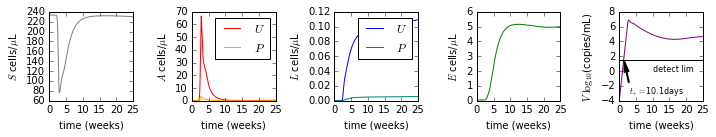

In [6]:
# parameters for viral dynamics model
vol = 1      # volume of blood [uL]
aS  = 70*vol;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4/vol  # infection rate of T-cells [uL/cells-day]/[uL]
dA  = 1.0       # active death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
thL = 5.2e-4    # latent clearance rate [1/day]
aL  = 0.015;    # latent proliferation rate [1/day] (Tcm)
xi  = 1e-5;     # latent activation rate [1/day]
dL  = aL-thL-xi # latent death rate
k   = 0.3/vol;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
aE  = 1e-4*vol;   #initial E cell concentration [cells/uL]*[uL]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250*vol;   #50 pct max E cell concentration [cells/uL]*[uL]

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dA; print(R0) # basic reproductive number

V0=1e-6 #start with 1 virion in body!

X0=np.array([aS/dS,0,0,0,0,aE/dE,V0])

t=np.linspace(0,25*7,1e4) #25 weeks

sol,vll,infpoz,t_fp,t_max=run_model1(t,X0,aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g) 

fig,axarr=plt.subplots(1,5,figsize=(10,2),dpi=rez,sharex=True)
    
axarr[0].plot(t/7,sol[:,0],'gray')
axarr[0].set_ylabel('$S$ cells/$\mu$L')
axarr[0].set_xticks(range(0,26,5))
#axarr[0].set_xlim([0,8])

axarr[1].plot(t/7,sol[:,1],'red')
axarr[1].plot(t/7,sol[:,2],'orange')
axarr[1].set_ylabel('$A$ cells/$\mu$L')
axarr[1].legend(['$U$','$P$'])

axarr[2].plot(t/7,sol[:,3],'blue')
axarr[2].plot(t/7,sol[:,4],'teal')
axarr[2].set_ylabel('$L$ cells/$\mu$L')
axarr[2].legend(['$U$','$P$'])

axarr[3].plot(t/7,sol[:,5],'green')
axarr[3].set_ylabel('$E$ cells/$\mu$L')

axarr[4].plot(t/7,vll,'purple')
axarr[4].axhline(np.log10(30),color='k')
#axarr[4].axvline(t_fp/7,ls='--',color='k',lw=0.5)
axarr[4].annotate('detect lim',xy=[10,0],fontsize=8)
axarr[4].annotate('$t_{+}=$'+str(round(t_fp,1))+'days',fontsize=8,xy=(t_fp/7, np.log10(30)), 
                  xytext=(3, -3),arrowprops=dict(color='black',width=1, headwidth=5,shrink=10))
axarr[4].set_ylabel('$V$ $\log_{10}$(copies/mL)')
axarr[4].set_yticks(range(-4,9,2))

for i in range(5):
    axarr[i].set_xlabel('time (weeks)')
        
plt.tight_layout()
plt.savefig('figures/det_model1.pdf')


In [7]:
#now see which parameter ranges fit in here
pnames_unix=['aS','dS','Bt0','tau','lam','dA','thL','xi','k','aE','dE','E50','w','p','g']

#for now and later, the time series and initial guess parameters
tt=np.linspace(0,100,1e4)
guessP=np.array([aS,dS,Bt0,tau,lam,dA,thL,xi,k,aE,dE,E50,w,p,g])

sampz=10**5

goodP_list=[]

bdz=1.#extra bounds for fitting shaded area

fposT=7

for i in range(sampz):
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=np.random.lognormal(0,2,[15])*guessP

    if aSr*Bt0r*taur*(1-lamr)*pr/gr/dSr/dAr<10: # basic reproductive number

        sol,vll,infpoz,t_fp,t_max=run_model1(tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

        if (vll>-10).all() & (vll>2).any():        

            t_shifted = tt[infpoz:]-tt[infpoz]

            loV,hiV = interpLO(t_shifted),interpHI(t_shifted) #the bounds

            #first positive must be before 3 weeks and t_max must be after 3 days since first positive
            if (t_fp<21.) & (t_max-t_fp>3.):

                if ~ ((vll[infpoz:]>hiV*bdz).any() | (vll[infpoz:]<loV/bdz).any()):
                    goodP_list.append([aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr])#,x0r])

                    #plt.plot(tt[infpoz:],vll[infpoz:])

#make a csv with values of goodP
gf=pd.DataFrame(goodP_list,columns=pnames_unix)
pd.DataFrame.to_csv(gf,'goodP_list.csv')


/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


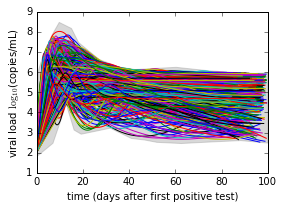

In [8]:
#plot all good list examples
plt.figure(figsize=(4,3),dpi=rez)

loV,hiV = interpLO(tt),interpHI(tt) #the bounds
for i in range(len(goodP_list)):
    aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr=goodP_list[i]

    sol,vll,infpoz,t_fp,t_max=run_model1(
        tt,X0,aSr,dSr,Bt0r,taur,lamr,dAr,thLr,xir,kr,aEr,dEr,E50r,wr,pr,gr)

    plt.plot(tt[infpoz:]-tt[infpoz],vll[infpoz:])#,color='k',alpha=0.5) #zero out by first positive

plt.fill_between(tt, loV, hiV, color='gray',alpha=0.3)
plt.xlabel('time (days after first positive test)')
plt.ylabel('viral load $\log_{10}$(copies/mL)')
plt.tight_layout()
plt.savefig('figures/robb_examples.pdf')



In [13]:
print(len(goodP_list))

773


In [9]:
#boxplots from robb, maybe fit to these?

#days to nadir
[17.878483268976264, 27.917385628280154, 30.934789888203735, 40.682980986119745, 41.7276975706514]

#days to EIA
[7.950909781228649,12.88320520610375,14.101772311072896, 18.04749340369393, 32.84449492559828]

#days to peak
[6.147116993275322, 6.320967513712819, 9.918987565458853, 13.052445835379505, 14.096931925353058, 17.868744873897068]

#peak log10 VL
[4.565059970202178, 6.35257087867727, 6.849094572557447, 7.663367820014483, 8.59685797501567]

#nadir log10 VL
[1.780762540024421, 3.6079697335034737, 4.422294201973418, 4.9188435063600515, 6.368654276730486]



[1.780762540024421,
 3.6079697335034737,
 4.422294201973418,
 4.9188435063600515,
 6.368654276730486]

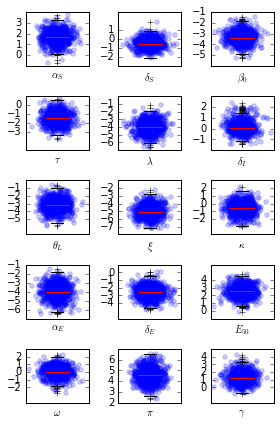

In [10]:
pnames_unix=['aS','dS','Bt0','tau','lam','dA','thL','xi','k','aE','dE','E50','w','p','g']

pnames=[r'$\alpha_S$',r'$\delta_S$',r'$\beta_0$',r'$\tau$',r'$\lambda$',
        r'$\delta_I$',r'$\theta_L$',r'$\xi$',r'$\kappa$',r'$\alpha_E$',
        r'$\delta_E$',r'$E_{50}$',r'$\omega$',r'$\pi$',r'$\gamma$']
        
fig,axarr=plt.subplots(5,3,sharey=False,figsize=(4,6),dpi=rez)
for j in range(15):
    ax=axarr[int(j/3.)][j%3]
    
    logpz=np.log10(np.array(goodP_list))
    
    #ax.violinplot(np.array(goodP_list)[:,j])#/guessP[j])
    ax.scatter(np.random.normal(1,0.05,len(goodP_list)),logpz[:,j],color='blue',alpha=0.2)#/guessP[j])
    ax.boxplot(logpz[:,j])#/guessP[j])
    ax.set_xlabel(pnames[j])
    ax.set_xticks([])
    ax.set_xlim([0.8,1.2])
    ax.set_yticks(range(int(np.min(logpz[:,j])),int(np.max(logpz[:,j])+1),1))
    #ax.set_yscale('log')
#axarr[1][0].set_ylabel('deviation from \n median value')
plt.tight_layout()
plt.savefig('figures/robb_fitparams.pdf')

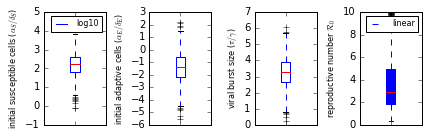

In [11]:
#make box plots of a few variable combos of interest

plt.figure(figsize=(6,2),dpi=rez)
plt.subplot(141)
plt.boxplot(np.log10(gf.aS/gf.dS))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'initial susceptible cells ($\alpha_S/\delta_S$)',fontsize=8)
#plt.xticks([1],[r'$\alpha_S/\delta_S$'])
plt.legend(['log10'],loc=1,fontsize=8)

plt.subplot(142)
plt.boxplot(np.log10(gf.aE/gf.dE))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'initial adaptive cells ($\alpha_E/\delta_E$)',fontsize=8)

plt.subplot(143)
plt.boxplot(np.log10(gf.p/gf.g))
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'viral burst size ($\pi/\gamma$)',fontsize=8)

plt.subplot(144)
c='blue'
plt.boxplot(gf.tau*(1-gf.lam)*gf.aS/gf.dS*gf.p/gf.g*gf.Bt0/gf.dA,patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c)
            #medianprops=dict(color='black'),
           )
#ax.scatter(np.random.normal(1,0.1,len(gf.tau)),gf.tau*(1-gf.lam)*gf.aS/gf.dS*gf.p/gf.g*gf.Bt0/gf.dA)#/guessP[j])
#plt.yscale('log')
plt.xticks([1],[''])
plt.ylabel(r'reproductive number $\mathcal{R}_0$',fontsize=8)
plt.legend(['linear'],loc=1,fontsize=8)

plt.tight_layout()
plt.savefig('figures/robb_fitparamcombos.pdf')

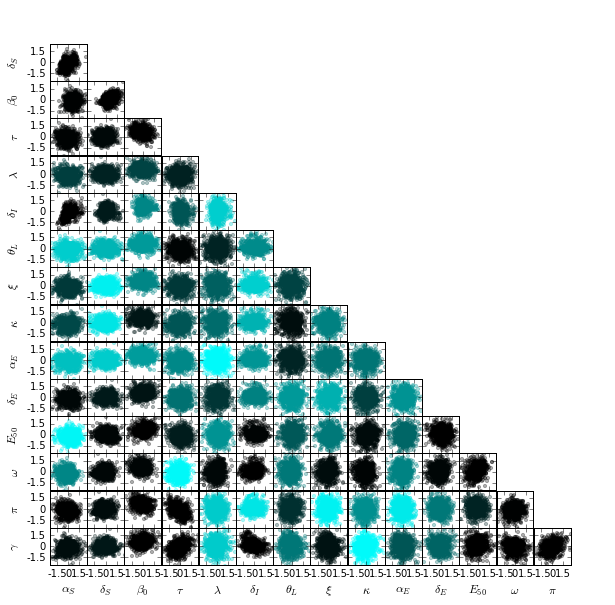

In [12]:
#correlate how variables affect one another to look at identifiability

fig,axarr=plt.subplots(15,15,sharey=True,sharex=True,figsize=(10,10),dpi=rez)

cz_range=np.linspace(0,1,11)

for i in range(15):
    for j in range(15):
        ax=axarr[i][j]

        #only plot bottom diagonal
        if j>i-1:
            ax.axis('off')
        else:
            pcorr=spearmanr(gf.iloc[:,i],gf.iloc[:,j])
            #pcorr=spearmanr(np.log10(gf.iloc[:,i+1]/guessP[i])),np.log10(gf.iloc[:,j+1]/guessP[j])))
            #if pcorr[1]<0.05:
            #    cz='crimson'
            #else:
            #    cz='green'
            ax.scatter(np.log10(gf.iloc[:,i]/guessP[i]),np.log10(gf.iloc[:,j]/guessP[j]),s=10, color=[0,pcorr[1],pcorr[1]],alpha=0.3)

    axarr[i][0].set_ylabel(pnames[i], fontsize=12)
    axarr[14][i].set_xlabel(pnames[i], fontsize=12)

ax.set_ylim([-2.5,2.5])
ax.set_xlim([-2.5,2.5])
ax.set_xticks([-1.5,0,1.5])
ax.set_yticks([-1.5,0,1.5])
ax.set_xticklabels([-1.5,0,1.5],fontsize=8)
ax.set_yticklabels([-1.5,0,1.5],fontsize=8)
fig.subplots_adjust(wspace=0.01, hspace=0.01)
fig.savefig('figures/robb_fitparams_varcorrs.pdf')


In [186]:
thai=pd.read_csv('data/wpd_thai.csv')
africa=pd.read_csv('data/wpd_africa.csv')
thai

,teal x,Unnamed: 1,sky blue rhombus,Unnamed: 3,blue circle,Unnamed: 5,red +,Unnamed: 7,sage *,Unnamed: 9,...,purple triang,Unnamed: 25,sage circle,Unnamed: 27,red rhombus,Unnamed: 29,blue *,Unnamed: 31,purple x,Unnamed: 33
0,X,Y,X,Y,X,Y,X,Y,X,Y,...,X,Y,X,Y,X,Y,X,Y,X,Y
1,0.9230769230769234,1.3024017265299834,1.2264957264957346,1.3071583623086607,1.2264957264957346,1.2897624593917163,0.7813390313390407,1.9392273435760385,1.2264957264957346,2.4204961489931414,...,2.2948717948718027,3.1487617970984694,2.8290598290598368,3.607992223763765,3.0961538461538503,5.584156089957693,10.307692307692317,4.929781100662863,4.1645299145299255,6.231240857783943
2,3.674857549857556,4.29335689898315,3.674857549857556,2.0608826913085414,3.8974358974359014,2.9248702818742887,3.674857549857556,3.24960272396645,4.5651709401709475,4.47307887855483,...,4.1645299145299255,4.206357758251545,5.767094017094028,4.9160463662367455,5.5000000000000036,6.217270609595258,2.2948717948718027,5.959939708476782,6.568376068376072,6.2868114005789355
3,7.903846153846164,5.47031016448852,6.568376068376079,3.3132717286424684,6.123219373219381,4.258466962414857,6.7909544159544275,4.716532309633511,7.013532763532776,5.1166291557473915,...,7.636752136752147,6.265893496394497,9.506410256410266,5.688274583354743,10.307692307692317,6.9129140331945935,6.835470085470096,7.657597845263176,10.841880341880351,6.244889950841854
4,11.019943019943032,6.682099840707055,10.129629629629637,4.385876339573733,11.24252136752138,5.319411857903841,10.352207977207986,5.713754674591347,12.132834757834768,6.490700303741384,...,11.376068376068385,7.260789270849391,13.245726495726505,6.620545107308633,48.235042735042754,5.053511467379201,10.0405982905983,8.464639278557113,14.047008547008556,5.528050288611411
5,22.14886039886041,5.875643623429194,14.136039886039892,5.209121833410411,17.919871794871806,5.09299749070791,14.358618233618241,6.247068453145607,14.136039886039892,6.455828209124801,...,15.382478632478641,7.288462137951115,19.655982905982913,6.481120959868454,66.1303418803419,4.864918469417466,12.978632478632488,6.79451484164911,17.7863247863248,4.595480019868797
6,24.15206552706554,5.6610138653375115,17.02955840455842,5.835258365734317,20.813390313390325,4.524615356068261,16.80698005698007,5.812072749487578,19.03276353276355,5.800386271117733,...,18.587606837606845,6.7942900330575675,22.059829059829074,5.715604884983642,73.8760683760684,4.140938458112806,16.45085470085471,6.028955946080194,21.52564102564104,4.4283294794717625
7,27.935897435897456,5.405722299299452,21.48112535612537,5.342196030237112,25.04237891737893,4.060555113075153,20.813390313390325,5.481390016500236,26.155270655270673,4.61138076723247,...,20.72435897435898,6.515869945018241,26.600427350427363,5.353588116403746,88.29914529914534,4.049901683709298,20.72435897435898,5.799158744840106,24.99786324786326,4.616066063751433
8,29.93910256410258,5.423037913433705,23.929487179487193,4.2229614785125795,27.935897435897456,3.555957955797634,24.15206552706554,5.115942240606568,27.935897435897456,4.692490279704707,...,25.532051282051295,6.042508692598872,35.414529914529936,4.796565952417655,174.8376068376069,4.102100097631158,24.19658119658121,5.83381138345066,33.2777777777778,4.469608618947295
9,34.83582621082623,5.504022532243974,27.935897435897456,3.5443606871863373,42.180911680911706,4.448376696412767,28.826210826210843,4.367731074684981,33.50035612535615,4.831434478643896,...,27.935897435897456,6.111995957727419,28.7371794871795,5.2421686963670915,322.80769230769243,4.221419933884862,28.7371794871795,5.729253978041553,39.95512820512822,5.290427607351454


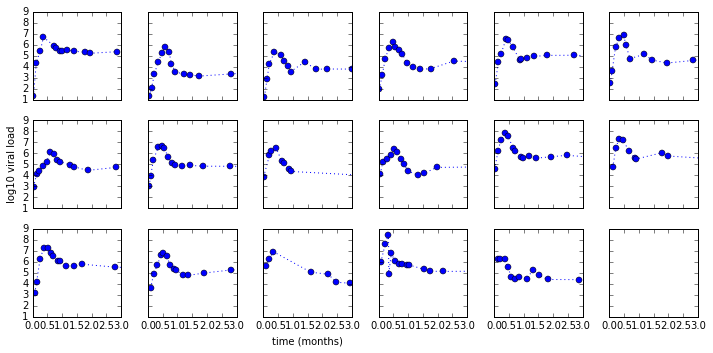

In [191]:
N_thai=int(len(thai.columns)/2)
fig,axarr=plt.subplots(3,6,sharey=True,sharex=True,figsize=(10,5),dpi=rez)

for i in range(N_thai):
    x=np.array(pd.to_numeric(thai.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    axarr[int(i/6)][i%6].plot(t_data,V_data,':o')
    #axarr[int(i/4)][i%4].legend({YES.columns[2*i]})
plt.xlim([0,3])
axarr[2][2].set_xlabel('time (months)')
axarr[1][0].set_ylabel('log10 viral load')
plt.tight_layout()

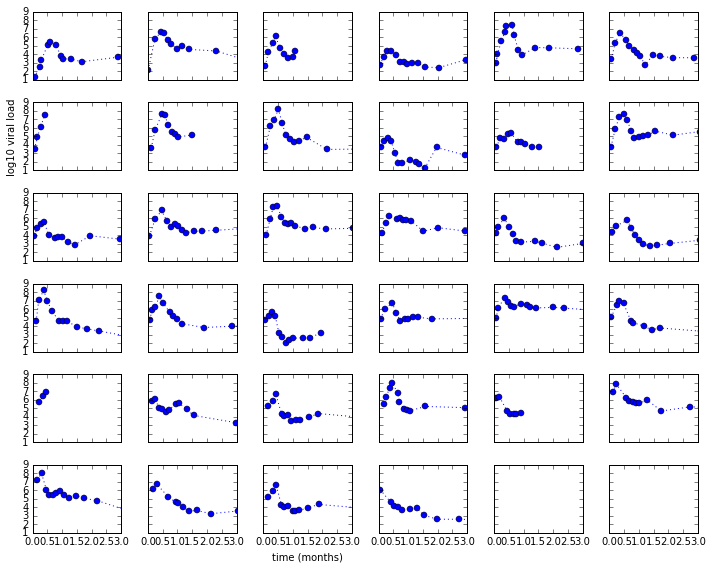

In [192]:
N_africa=int(len(africa.columns)/2)
fig,axarr=plt.subplots(6,6,sharey=True,sharex=True,figsize=(10,8),dpi=rez)

for i in range(N_africa):
    x=np.array(pd.to_numeric(africa.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(africa.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    axarr[int(i/6)][i%6].plot(t_data,V_data,':o')
    #axarr[int(i/4)][i%4].legend({YES.columns[2*i]})
plt.xlim([0,3])
axarr[5][2].set_xlabel('time (months)')
axarr[1][0].set_ylabel('log10 viral load')
plt.tight_layout()

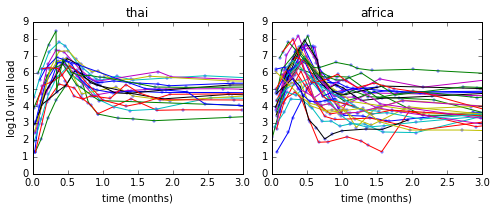

In [252]:
#plot all curves and look at mean and variances
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
plt.figure(figsize=(7,3),dpi=rez)

plt.subplot(121)
for i in range(N_thai):
    x=np.array(pd.to_numeric(thai.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    plt.plot(t_data,V_data)
    plt.scatter(t_data,V_data,lw=0,s=10,alpha=0.5)
plt.ylabel('log10 viral load')
plt.xlim([0,3])
plt.title('thai')
plt.xlabel('time (months)')

plt.subplot(122)
for i in range(N_africa):
    x=np.array(pd.to_numeric(africa.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(africa.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    plt.plot(t_data,V_data)
    plt.scatter(t_data,V_data,lw=0,s=10,alpha=0.5)
plt.title('africa')

plt.xlim([0,3])
plt.xlabel('time (months)')
plt.tight_layout()
fig.savefig('figures/myrobb_data.pdf')


In [116]:
#function to make arrays for boundaries
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

In [153]:
# MODEL 1

#parametesr to fit
aS  = 70;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
tau = 0.05      # productive infection probability []
k   = 0.3;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guess=aS,dS,tau,k,dE,E50,w

po_arr1=np.zeros([len(guess),N]); pc_arr1=np.zeros([len(guess),len(guess),N]); #intialize arrays
for i in range(N):
    
    x=np.array(pd.to_numeric(YES.iloc[1:,2*i].dropna())) #keep in days
    y=np.array(pd.to_numeric(YES.iloc[1:,2*i+1]))
    
    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model1(tt,aS,dS,tau,k,dE,E50,w):  

        #peg some parameters
        Bt0 = 1e-4  # infection rate of T-cells [uL/cells-day]/[uL]
        dI  = 1.0       # active death rate [1/day]
        p   = 5e4       # burst rate of virus from cells [virions/cell]
        g   = 23        # virus clearance rate [1/day]
        lam = 1e-4      # latency probability []
        thL = 5.2e-4    # latent clearance rate [1/day]
        xi  = 1e-5;     # latent activation rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data

        #calculate the rest of initial conditions
        AU0=g/p*V0*(1-tau)
        AP0=g/p*V0*tau
        LU0=g/p*V0*(1-tau)*lam
        LP0=g/p*V0*tau*lam

        X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(model1, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model
        vll=np.log10(sol[:,6]/vol*1e3) #viral load as usual units copies/mL
        return vll

    #model fit
    po, pc = curve_fit(fit_model1, t_data, V_data, p0=guess, bounds=make_bounds(guess,1000),sigma=0.1,absolute_sigma=False,
                        max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)


    aS,dS,tau,k,dE,E50,w=po
    
    po_arr1[:,i]=po
    pc_arr1[:,:,i]=pc
    

`xtol` termination condition is satisfied.
Function evaluations: 55, initial cost: 3.4332e+02, final cost 1.1971e+02, first-order optimality 6.77e+01.
`xtol` termination condition is satisfied.
Function evaluations: 29, initial cost: 1.9948e+03, final cost 1.3441e+03, first-order optimality 1.51e+06.
`xtol` termination condition is satisfied.
Function evaluations: 51, initial cost: 1.2482e+03, final cost 1.0682e+02, first-order optimality 2.06e+04.
`xtol` termination condition is satisfied.
Function evaluations: 41, initial cost: 7.9804e+02, final cost 6.3784e+01, first-order optimality 5.26e+02.
`xtol` termination condition is satisfied.
Function evaluations: 34, initial cost: 3.8334e+02, final cost 5.8899e+01, first-order optimality 1.74e+02.
`xtol` termination condition is satisfied.
Function evaluations: 37, initial cost: 3.3932e+02, final cost 1.0065e+02, first-order optimality 5.17e+02.
`xtol` termination condition is satisfied.
Function evaluations: 39, initial cost: 5.2706e+02,

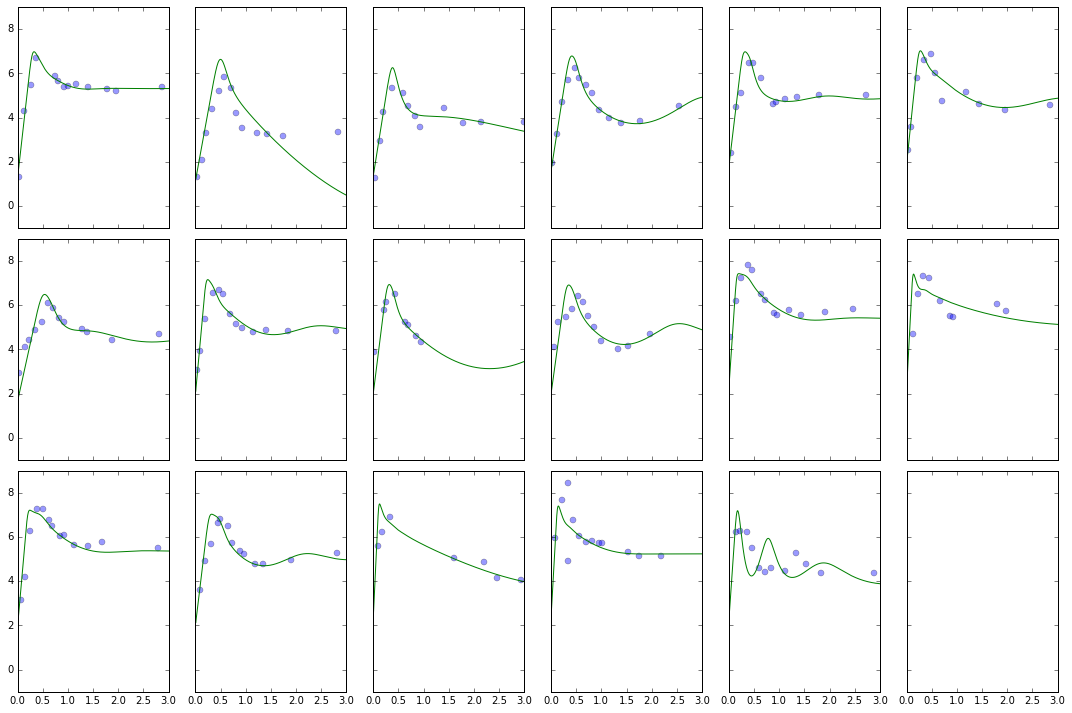

In [155]:
#plot MODEL 1
fig,axarr=plt.subplots(3,6,sharey=True,sharex=True,figsize=(15,10),dpi=rez)

t_sim=np.linspace(0,400,1e4);

for i in range(N):
    
    x=np.array(pd.to_numeric(YES.iloc[1:,2*i].dropna())) #keep in days
    y=np.array(pd.to_numeric(YES.iloc[1:,2*i+1]))
    
    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model1(tt,aS,dS,tau,k,dE,E50,w):  

        #peg some parameters
        Bt0 = 1e-4  # infection rate of T-cells [uL/cells-day]/[uL]
        dI  = 1.0       # active death rate [1/day]
        p   = 5e4       # burst rate of virus from cells [virions/cell]
        g   = 23        # virus clearance rate [1/day]
        lam = 1e-4      # latency probability []
        thL = 5.2e-4    # latent clearance rate [1/day]
        xi  = 1e-5;     # latent activation rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data

        #calculate the rest of initial conditions
        AU0=g/p*V0*(1-tau)
        AP0=g/p*V0*tau
        LU0=g/p*V0*(1-tau)*lam
        LP0=g/p*V0*tau*lam

        X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(model1, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model
        vll=np.log10(sol[:,6]/vol*1e3) #viral load as usual units copies/mL
        return vll

    aS,dS,tau,k,dE,E50,w=po_arr1[:,i]
    
    V_sim=fit_model1(t_sim,aS,dS,tau,k,dE,E50,w)
    
    axarr[int(i/6)][i%6].plot(t_data/30,V_data,'o',alpha=0.4)
    axarr[int(i/6)][i%6].plot(t_sim/30,V_sim,'-')
    
plt.xlim([0,3])
plt.tight_layout()

In [233]:
#MODEL 2

def model2(X,t,aS,dS,Bt0,tau,p,g,dA,k,aE,dE,E50,w):
    dY = np.zeros(4);
    S=X[0]; A=X[1]; E=X[2]; V=X[3];
    dY[0] = aS - dS*S - Bt0*S*V       #susceptible cells
    dY[1] = Bt0*S*V - dA*A - k*E*A    #active unproductively infected
    dY[2] = w*E*A/(E+E50) + aE - dE*E;   #adaptive immune system
    dY[3] = p*tau*A - g*V - Bt0*S*V
    return dY

#fit the model!

#parametesr to fit
aS  = 70;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt0 = 1e-4;
tau = 0.05;
k   = 0.3;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guess=aS,dS,Bt0,tau,p,k,dE,E50,w

N=N_thai+N_africa

po_arr2=np.zeros([len(guess),N]); pc_arr2=np.zeros([len(guess),len(guess),N]); #intialize arrays
for i in range(N):
    
    if i<N_thai:
        x=np.array(pd.to_numeric(thai.iloc[1:,2*i].dropna())) #keep in days
        y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    else:
        x=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)].dropna())) #keep in days
        y=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)+1]))    
    
    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model2(tt,aS,dS,Bt0,tau,p,k,dE,E50,w):  

        #peg some parameters
        dA  = 1.0       # active death rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]
        g   = 23;
        
        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data
        
        #calculate the rest of initial conditions
        A0=V0/p*g*tau

        X0=np.array([S0,A0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(model2, X0, tt, (aS,dS,Bt0,tau,p,g,dA,k,aE,dE,E50,w), mxstep=10000) #solve model
        vll=np.log10(sol[:,3]*1e3) #viral load as usual units copies/mL
        return vll

    #model fit
    po, pc = curve_fit(fit_model2, t_data, V_data, p0=guess, bounds=make_bounds(guess,10),sigma=0.5,absolute_sigma=False,
                        max_nfev=1e4, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)


    aS,dS,Bt0,tau,p,k,dE,E50,w=po
    
    po_arr2[:,i]=po
    pc_arr2[:,:,i]=pc
    

`xtol` termination condition is satisfied.
Function evaluations: 37, initial cost: 1.2412e+01, final cost 5.3764e+00, first-order optimality 2.17e+00.
`xtol` termination condition is satisfied.
Function evaluations: 62, initial cost: 8.9908e+01, final cost 2.9416e+00, first-order optimality 1.25e+01.
`xtol` termination condition is satisfied.
Function evaluations: 43, initial cost: 5.2313e+01, final cost 4.7703e+00, first-order optimality 5.92e+00.
`xtol` termination condition is satisfied.
Function evaluations: 77, initial cost: 3.5371e+01, final cost 4.2726e+00, first-order optimality 6.60e+00.
`xtol` termination condition is satisfied.
Function evaluations: 47, initial cost: 1.5123e+01, final cost 2.4994e+00, first-order optimality 6.34e+00.
`xtol` termination condition is satisfied.
Function evaluations: 55, initial cost: 1.2106e+01, final cost 3.6533e+00, first-order optimality 1.29e+01.
`xtol` termination condition is satisfied.
Function evaluations: 61, initial cost: 2.4772e+01,

/Users/danielreeves/anaconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


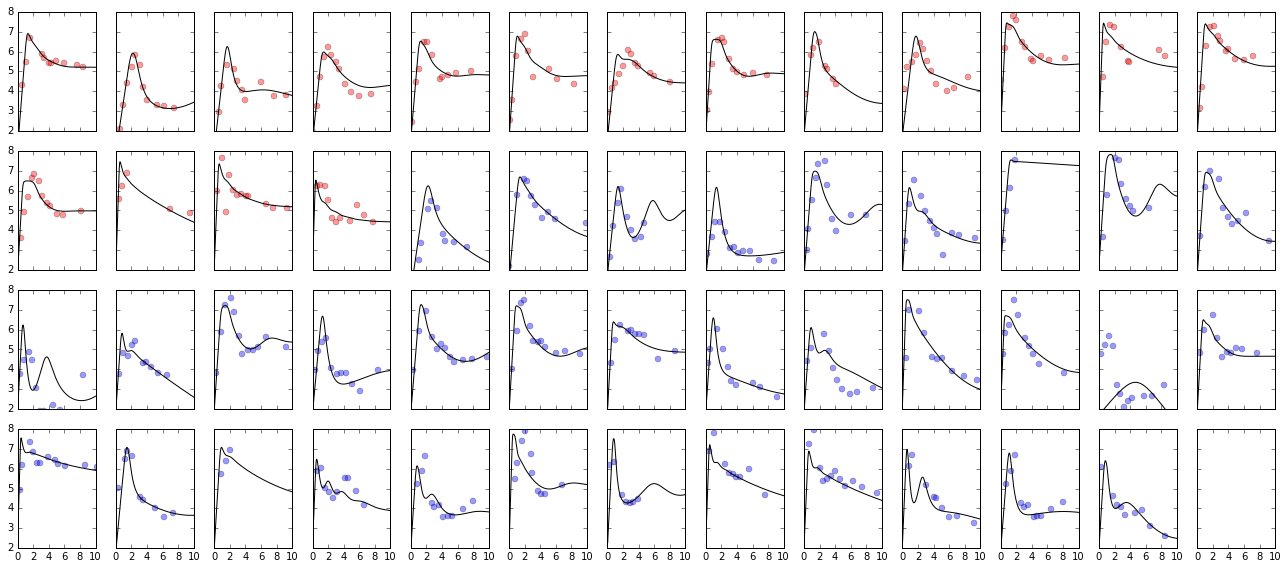

In [244]:
#plot MODEL 2

fig,axarr=plt.subplots(4,13,sharey=True,sharex=True,figsize=(18,8),dpi=rez)

t_sim=np.linspace(0,400,1e4);

for i in range(N):
    
    if i<N_thai:
        x=np.array(pd.to_numeric(thai.iloc[1:,2*i].dropna())) #keep in days
        y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
        col='red'
    else:
        x=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)].dropna())) #keep in days
        y=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)+1]))    
        col='blue'

    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model2(tt,aS,dS,Bt0,tau,p,k,dE,E50,w):  

        #peg some parameters
        dA  = 1.0       # active death rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]
        g   = 23;
        
        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data
        
        #calculate the rest of initial conditions
        A0=V0/p*g*tau

        X0=np.array([S0,A0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(model2, X0, tt, (aS,dS,Bt0,tau,p,g,dA,k,aE,dE,E50,w), mxstep=10000) #solve model
        vll=np.log10(sol[:,3]*1e3) #viral load as usual units copies/mL
        return vll
    
    aS,dS,Bt0,tau,p,k,dE,E50,w=po_arr2[:,i]
    
    V_sim=fit_model2(t_sim,aS,dS,Bt0,tau,p,k,dE,E50,w)
    ax=axarr[int(i/13)][i%13]
    ax.plot(t_data/7,V_data,'o',alpha=0.4,color=col)
    ax.plot(t_sim/7,V_sim,'-',color='k')
    
plt.xlim([0,10])
plt.ylim([2,8])
plt.tight_layout()
fig.savefig('figures/myrobb_fits.pdf')


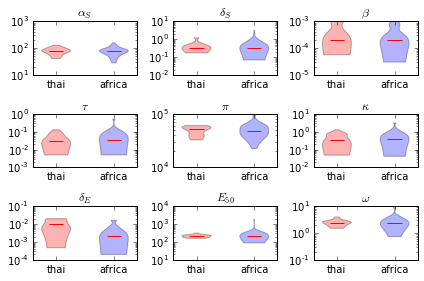

In [253]:
pz=[r'$\alpha_S$',r'$\delta_S$',r'$\beta$',r'$\tau$',r'$\pi$',r'$\kappa$',r'$\delta_E$',r'$E_{50}$',r'$\omega$']
#pz=['aS','dS','Bt0','tau','p','k','dE','E50','w']

for i in range(9):
    plt.subplot(331+i)
    violzT=plt.violinplot([po_arr2[i,:N_thai]],positions=[1],showextrema=False,showmedians=True)
    violzA=plt.violinplot([po_arr2[i,N_thai:]],positions=[2],showextrema=False,showmedians=True)

    for pc in violzT['bodies']:
        pc.set_facecolor('red')
        #pc['cmedians'].set_edgecolor('k')
    for pc in violzA['bodies']:
        pc.set_facecolor('blue')

    plt.yscale('log')
    plt.title(pz[i])
    plt.xticks([1,2],['thai','africa'])
plt.tight_layout()
fig.savefig('figures/myrobb_violins.pdf')


In [145]:
#MODEL 3 HIV model (don't need Abs yet)
def model3(X,t,aS,dS,Bt_hat,dA,k,aE,dE,E50,w):
    dY = np.zeros(3);
    S=X[0]; A=X[1]; E=X[2];    
    dY[0] = aS - dS*S - Bt_hat*S*A       #susceptible cells
    dY[1] = Bt_hat*S*A - dA*A - k*E*A    #active unproductively infected
    dY[2] = w*E*A/(E+E50) + aE - dE*E;   #adaptive immune system
    return dY

#fit the model!

#parametesr to fit
aS  = 70;   #constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;   #susceptible death rate [1/day] 
Bt_hat = Bt0*p/g*tau
k   = 0.3;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guess=aS,dS,Bt_hat,k,dE,E50,w

po_arr3=np.zeros([len(guess),N]); pc_arr3=np.zeros([len(guess),len(guess),N]); #intialize arrays
for i in range(N):
    
    x=np.array(pd.to_numeric(YES.iloc[1:,2*i].dropna())) #keep in days
    y=np.array(pd.to_numeric(YES.iloc[1:,2*i+1]))
    
    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model3(tt,aS,dS,Bt_hat,k,dE,E50,w):  

        #peg some parameters
        dA  = 1.0       # active death rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data
        
        #calculate the rest of initial conditions
        A0=V0/p*g*tau

        X0=np.array([S0,A0,E0]) #start with a single infected cell
        sol=spi.odeint(model3, X0, tt, (aS,dS,Bt_hat,dA,k,aE,dE,E50,w), mxstep=10000) #solve model
        vll=np.log10(sol[:,1]*1e3*p/g*tau) #viral load as usual units copies/mL
        return vll

    #model fit
    po, pc = curve_fit(fit_model3, t_data, V_data, p0=guess, bounds=make_bounds(guess,1000),sigma=1,absolute_sigma=True,
                        max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)


    aS,dS,Bt_hat,k,dE,E50,w=po
    
    po_arr3[:,i]=po
    pc_arr3[:,:,i]=pc
    

`xtol` termination condition is satisfied.
Function evaluations: 56, initial cost: 1.2321e+01, final cost 6.4182e+00, first-order optimality 1.55e-01.
`xtol` termination condition is satisfied.
Function evaluations: 46, initial cost: 1.8573e+01, final cost 9.3920e+00, first-order optimality 6.18e+00.
`xtol` termination condition is satisfied.
Function evaluations: 39, initial cost: 1.2336e+01, final cost 7.0701e+00, first-order optimality 5.09e+00.
`xtol` termination condition is satisfied.
Function evaluations: 45, initial cost: 1.3333e+01, final cost 8.3620e+00, first-order optimality 1.19e+02.
`xtol` termination condition is satisfied.
Function evaluations: 48, initial cost: 1.3162e+01, final cost 9.0709e+00, first-order optimality 2.76e-01.
`xtol` termination condition is satisfied.
Function evaluations: 45, initial cost: 1.2672e+01, final cost 9.6010e+00, first-order optimality 2.04e+00.
`xtol` termination condition is satisfied.
Function evaluations: 46, initial cost: 1.5198e+01,

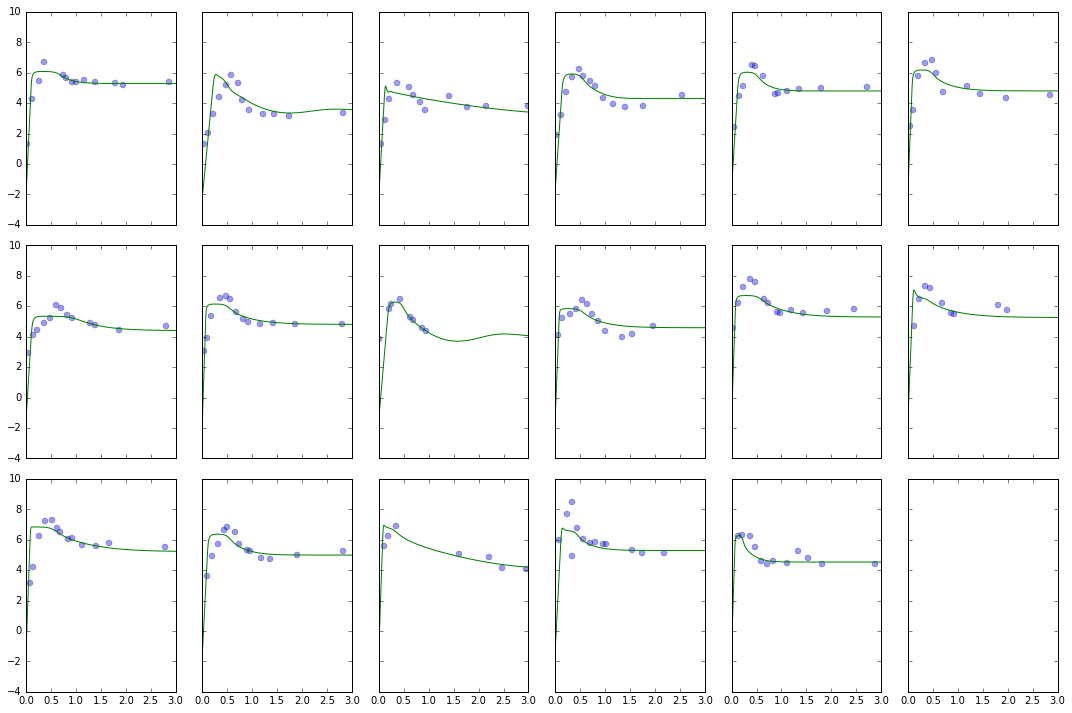

In [146]:
#plot best fits
fig,axarr=plt.subplots(3,6,sharey=True,sharex=True,figsize=(15,10),dpi=rez)

t_sim=np.linspace(0,400,1e4);

for i in range(N):
    
    x=np.array(pd.to_numeric(YES.iloc[1:,2*i].dropna())) #keep in days
    y=np.array(pd.to_numeric(YES.iloc[1:,2*i+1]))
    
    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model3(tt,aS,dS,Bt_hat,k,dE,E50,w):  

        #peg some parameters
        dA  = 1.0       # active death rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data
        
        #calculate the rest of initial conditions
        A0=V0/p*g*tau

        X0=np.array([S0,A0,E0]) #start with a single infected cell
        sol=spi.odeint(model3, X0, tt, (aS,dS,Bt_hat,dA,k,aE,dE,E50,w), mxstep=10000) #solve model
        vll=np.log10(sol[:,1]*1e3*p/g*tau) #viral load as usual units copies/mL
        return vll
    
    aS,dS,Bt_hat,k,dE,E50,w=po_arr3[:,i]
    
    V_sim=fit_model3(t_sim,aS,dS,Bt_hat,k,dE,E50,w)
    axarr[int(i/6)][i%6].plot(t_data/30,V_data,'o',alpha=0.4)
    axarr[int(i/6)][i%6].plot(t_sim/30,V_sim,'-')
    
plt.xlim([0,3])
plt.tight_layout()

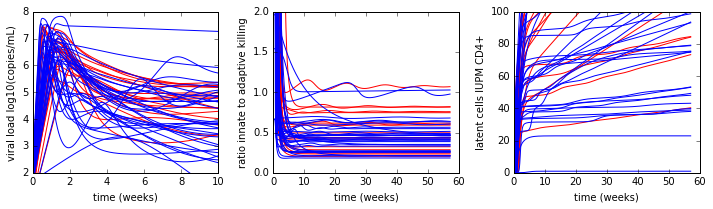

In [263]:
#plot MODEL 2 a different way!
plt.figure(figsize=(10,3),dpi=rez)
t_sim=np.linspace(0,400,1e4);

for i in range(N):
    
    if i<N_thai:
        x=np.array(pd.to_numeric(thai.iloc[1:,2*i].dropna())) #keep in days
        y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
        col='red'
    else:
        x=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)].dropna())) #keep in days
        y=np.array(pd.to_numeric(africa.iloc[1:,2*(i-N_thai)+1]))    
        col='blue'

    indz=np.argsort(x) #make sure time is in order
        
    t_data=x[indz]; V_data=y[indz]
    
    #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    
    #makes model to be fit
    def fit_model2(tt,aS,dS,Bt0,tau,p,k,dE,E50,w):  

        #peg some parameters
        dA  = 1.0       # active death rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]
        g   = 23;
        
        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data
        
        #calculate the rest of initial conditions
        A0=V0/p*g*tau

        X0=np.array([S0,A0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(model2, X0, tt, (aS,dS,Bt0,tau,p,g,dA,k,aE,dE,E50,w), mxstep=10000) #solve model
        vll=np.log10(sol[:,3]*1e3) #viral load as usual units copies/mL
        return sol,vll
    
    aS,dS,Bt0,tau,p,k,dE,E50,w=po_arr2[:,i]
    
    sol,V_sim=fit_model2(t_sim,aS,dS,Bt0,tau,p,k,dE,E50,w)
    
    plt.subplot(131)
    #plt.plot(t_data/7,V_data,'o',alpha=0.4,color=col)
    plt.plot(t_sim/7,V_sim,'-',color=col)
    plt.xlim([0,10])
    plt.ylim([2,8])
    plt.xlabel('time (weeks)')
    plt.ylabel('viral load log10(copies/mL)')

    #ratio of death rates
    plt.subplot(132)
    plt.plot(t_sim/7,sol[:,1]*dA/(sol[:,1]*sol[:,2]*k),'-',color=col)
    plt.xlabel('time (weeks)')
    plt.ylabel('ratio innate to adaptive killing')
    plt.ylim([0,2])
    
    #latent cells IUPM CD4+
    plt.subplot(133)
    
    L=np.cumsum(Bt0*lam*sol[:,0]*sol[:,3]*t_sim[1])
    
    IUPM = L/1e3*1e6 #ratio of L/CD4+ in millions
    
    plt.plot(t_sim/7,IUPM,'-',color=col)
    plt.xlabel('time (weeks)')
    plt.ylabel('latent cells IUPM CD4+')
    plt.ylim([0,100])

plt.tight_layout()
fig.savefig('figures/myrobb_ALL.pdf')
